In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import math  # Needed for functions like log, exp, etc.


In [ ]:
#--- Fixed weights simulation ---
# Paramètres globaux
lambda_a = 1.0
lambda_b = 1.0
ka = 0.3
kb = 0.8
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2


def neuron_dynamics(t, y, x_in, y_in, w_p=1.0, w_n=1.0):
    a, b = y
    da_dt = w_p * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = w_n * y_in + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def simulate_layer(X_bulk_vec, Y_bulk_vec, n_neurons, lambda_override=None, neuron_weights=None):
    X_total = np.sum(X_bulk_vec)
    Y_total = np.sum(Y_bulk_vec)
    lambda_total = lambda_override if lambda_override is not None else (X_total + Y_total) / n_neurons

    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_bulk_vec / X_total if X_total > 0 else np.zeros_like(X_bulk_vec)
    q_vec = Y_bulk_vec / Y_total if Y_total > 0 else np.zeros_like(Y_bulk_vec)

    a_vec = []
    b_vec = []
    for i in range(n_neurons):
        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0

        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_bulk_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_bulk_vec)

        x_in = np.sum(x_vec)
        y_in = np.sum(y_vec)

        w_p_x, w_p_y = neuron_weights[i] if neuron_weights is not None else (1.0, 1.0)

        sol = solve_ivp(
            neuron_dynamics, [0, 0], [0.0, 0.0],
            args=(x_in, y_in, w_p_x, w_p_y),
            method='LSODA'
        )

        a_vec.append(sol.y[0, -1])
        b_vec.append(sol.y[1, -1])

    return np.array(a_vec), np.array(b_vec)

def simulate_network_sum(X_vec, Y_vec, n_layers, n_neurons, lambda_override=None, neuron_weights=None):
    for _ in range(n_layers):
        a_out, b_out = simulate_layer(X_vec, Y_vec, n_neurons, lambda_override=lambda_override, neuron_weights=neuron_weights)
        X_vec = np.array([np.sum(a_out)])
        Y_vec = np.array([np.sum(b_out)])
    return np.sum(X_vec), np.sum(Y_vec)

def run_simulation(n_layers, n_neurons, n_points, lambda_override=None, neuron_weights=None):
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
    Z_grid = np.zeros_like(X_grid)

    total_points = X_grid.size
    iterator = tqdm(range(total_points), desc="Simulation")

    for idx in iterator:
        i = idx // X_grid.shape[1]
        j = idx % X_grid.shape[1]
        X_input = X_grid[i, j]
        Y_input = Y_grid[i, j]
        a_final, b_final = simulate_network_sum(np.array([X_input]), np.array([Y_input]),
                                               n_layers, n_neurons,
                                               neuron_weights=neuron_weights,
                                               lambda_override=lambda_override)
        Z_grid[i, j] = a_final / (a_final + b_final) if (a_final + b_final) > 0 else 0.0
    return X_grid, Y_grid, Z_grid


Simulation: 100%|██████████| 2500/2500 [00:16<00:00, 152.69it/s]


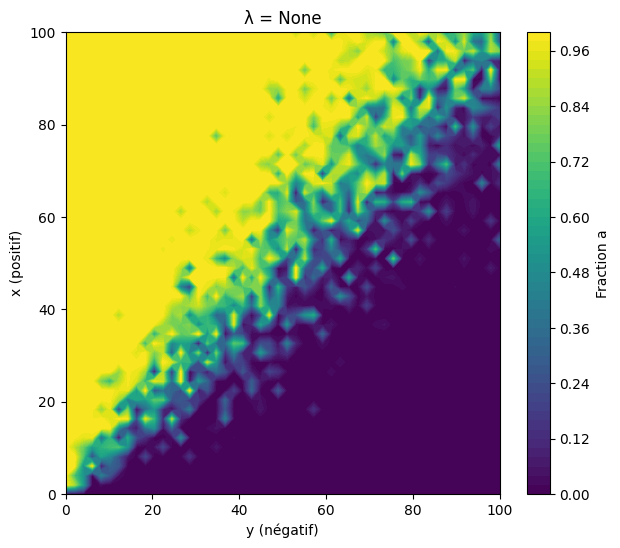

In [9]:

if __name__ == "__main__":

      # Paramètres globaux
    lambda_a = 1.0
    lambda_b = 1.0
    ka = 0.8
    kb = 0.8
    eta_a = 0.1
    eta_b = 0.1
    mu_ab = 0.4

    
    approach = 1
    n_layers = 1
    n_neurons = 3
    n_points = 50
    lambda_val = None

    # Poids initiaux
    initial_weights = [
        [1.0,1.0],
        [0.8,0.8],
        [0.8,0.8],
    ]
    assert len(initial_weights) == n_neurons

    # Grille fixe pour affichage
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)

    # Calcul de la simulation avec la barre de progression tqdm
    weights = [(w[0], w[1]) for w in initial_weights]
    X_grid, Y_grid, Z_grid = run_simulation(
        n_layers, n_neurons, n_points,
        lambda_override=lambda_val,
        neuron_weights=weights
    )

    # Affichage statique
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(im, ax=ax, label="Fraction a")
    ax.set_xlabel("y (négatif)")
    ax.set_ylabel("x (positif)")
    ax.set_title(f"λ = {lambda_val}")

    plt.show()
